In [1]:
pip install rdkit numpy pandas scikit-learn matplotlib joblib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 762.0 kB/s eta 0:00:10
   -- ------------------------------------- 0.5/8.1 MB 762.0 kB/s eta 0:00:10
   --- ------------------------------------ 0.8/8.1 MB 729.2 kB/s eta 0:00:11
   --- ------------------------------------ 0.8/8.1 MB 729.2 kB/s eta 0:00:11
   ----- ---------------------------------- 1.0/8.1 MB 671.0 kB/s eta 0:00:11
   ----- ---------------------------------- 1.0/8.1 MB 671.0 kB/s eta 0:00:11
   ----- ---------------------------------- 1.0/8.1 MB 671.0 kB/s eta 0:00:11
   ------ --------------------------------- 1.3/8.1 MB 621.6 kB/s eta 0:00:11
   ------ -----------------------------


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import joblib
import matplotlib.pyplot as plt

In [3]:
def smiles_to_fingerprint(smiles: str, radius: int = 2, n_bits: int = 2048) -> np.ndarray:
    """Convert SMILES to Morgan fingerprint (ECFP4)."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fp)


def prepare_data(df: pd.DataFrame) -> tuple:
    """
    Prepare features and targets from your dataset.

    Expected DataFrame columns: ['smiles', 'pic50', 'logp', 'atoms']

    Returns:
        X: Fingerprint features
        y: Target properties [pic50, logp, atoms]
        valid_smiles: List of valid SMILES
    """
    X_list = []
    y_list = []
    valid_smiles = []

    for idx, row in df.iterrows():
        # Skip rows with missing values
        if pd.isna(row['pIC50']) or pd.isna(row['logP']) or pd.isna(row['num_atoms']):
            continue

        # Generate fingerprint
        fp = smiles_to_fingerprint(row['SMILES'])
        if fp is None:
            print(f"⚠ Invalid SMILES at index {idx}: {row['SMILES']}")
            continue

        X_list.append(fp)
        y_list.append([row['pIC50'], row['logP'], row['num_atoms']])
        valid_smiles.append(row['SMILES'])

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"✓ Processed {len(X)} valid molecules from {len(df)} total")
    print(f"  Features shape: {X.shape}")
    print(f"  Targets shape: {y.shape}")

    return X, y, valid_smiles


In [8]:
def train_model(X, y, test_size=0.2, random_state=42):
    """
    Train Multi Output Regressor model for all 3 properties.

    Args:
        X: Feature matrix
        y: Target matrix (columns: pic50, logp, atoms)

    Returns:
        model: Trained model
        X_test, y_test, y_pred: Test data and predictions
    """

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=True
    )

    print(f"\nTraining set: {len(X_train)} molecules")
    print(f"Test set: {len(X_test)} molecules")

    # Define model
    # Using separate RF for each property (often works better)
    #base_estimator = RandomForestRegressor(
    #    n_estimators=100,
    #    max_depth=20,
    #    min_samples_split=5,
    #    min_samples_leaf=2,
    #    random_state=random_state,
    #    n_jobs=-1,
    #    verbose=0
    #)

    model = MultiOutputRegressor(Ridge(alpha=1.0))

    # Train
    print("\nTraining Multi Output Regression model...")
    model.fit(X_train, y_train)
    print("✓ Training complete")

    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    return model, X_train, X_test, y_train, y_test, y_pred_train, y_pred_test

In [9]:
def evaluate_model(y_true, y_pred, dataset_name="Test"):
    """Calculate metrics for each property."""

    property_names = ["pIC50", "logP", "num_atoms"]
    metrics = {}

    print(f"\n{'='*60}")
    print(f"{dataset_name} Set Performance")
    print(f"{'='*60}")

    for i, prop in enumerate(property_names):
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])

        metrics[prop] = {"r2": r2, "rmse": rmse, "mae": mae}

        print(f"\n{prop}:")
        print(f"  R² score:  {r2:.4f}")
        print(f"  RMSE:      {rmse:.4f}")
        print(f"  MAE:       {mae:.4f}")

    return metrics

In [10]:
def plot_predictions(y_true, y_pred, property_names=["pIC50", "logP", "atoms"], filename="predictions.png"):
    """Create scatter plots of true vs predicted values."""

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for i, (ax, prop) in enumerate(zip(axes, property_names)):
        ax.scatter(y_true[:, i], y_pred[:, i], alpha=0.5, s=20)

        # Perfect prediction line
        min_val = min(y_true[:, i].min(), y_pred[:, i].min())
        max_val = max(y_true[:, i].max(), y_pred[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')

        ax.set_xlabel(f'True {prop}')
        ax.set_ylabel(f'Predicted {prop}')
        ax.set_title(f'{prop} Predictions')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\n✓ Plots saved to {filename}")

Training 3-Property Prediction Model

Dataset info:
  Total molecules: 16087

Property ranges:
              pIC50          logP     num_atoms
count  15037.000000  16087.000000  16087.000000
mean       0.998739      2.256600     18.749984
std        2.479588      1.609861      8.428888
min        0.000000     -5.395600      3.000000
25%        0.000000      1.214900     13.000000
50%        0.010000      2.163200     17.000000
75%        0.130000      3.232440     23.000000
max       10.970000     15.879200     85.000000

------------------------------------------------------------
Preparing fingerprints...


[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerator
[16:19:11] DEPRECATION WARNING: please use MorganGenerat

✓ Processed 15037 valid molecules from 16087 total
  Features shape: (15037, 2048)
  Targets shape: (15037, 3)

------------------------------------------------------------

Training set: 12029 molecules
Test set: 3008 molecules

Training Multi Output Regression model...
✓ Training complete

------------------------------------------------------------

Training Set Performance

pIC50:
  R² score:  0.9612
  RMSE:      0.4913
  MAE:       0.3532

logP:
  R² score:  0.8830
  RMSE:      0.4940
  MAE:       0.3543

num_atoms:
  R² score:  0.9560
  RMSE:      1.7818
  MAE:       1.1970

Test Set Performance

pIC50:
  R² score:  0.9337
  RMSE:      0.6227
  MAE:       0.4272

logP:
  R² score:  0.8165
  RMSE:      0.6117
  MAE:       0.4300

num_atoms:
  R² score:  0.9372
  RMSE:      2.0633
  MAE:       1.4517

✓ Plots saved to predictions.png

✓ Model saved to multitarget_model.pkl

Testing Prediction on New Molecule

SMILES: c1ccc(cc1)CC(C)O
  Predicted pIC50: 0.88
  Predicted logP:  1.41


[16:19:36] DEPRECATION WARNING: please use MorganGenerator


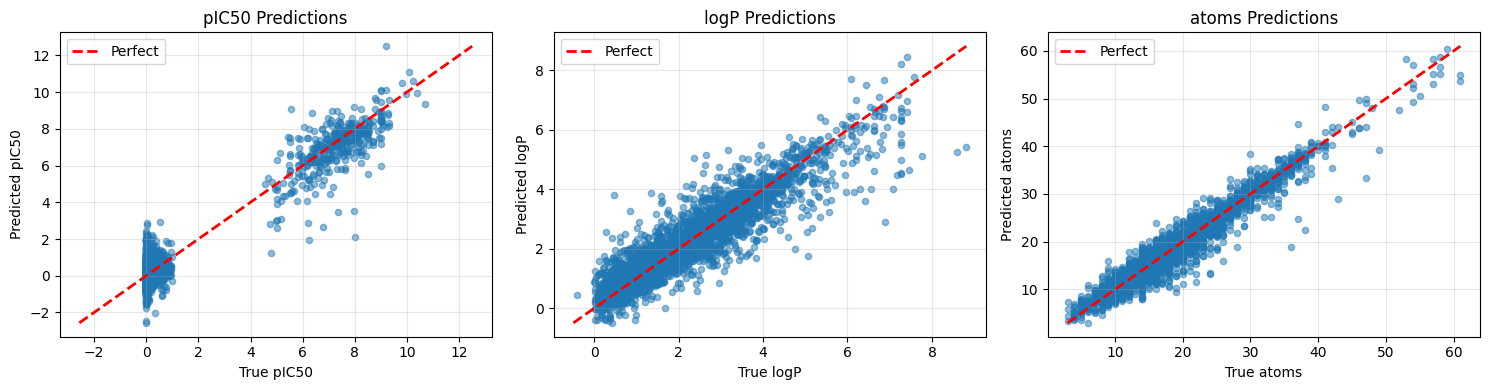

In [11]:
def main():
    # Load your dataset
    # Expected format: CSV with columns [smiles, pic50, logp, atoms]

    print("="*60)
    print("Training 3-Property Prediction Model")
    print("="*60)

    df = pd.read_csv("SMILES_Big_Data_Set.csv")

    print(f"\nDataset info:")
    print(f"  Total molecules: {len(df)}")
    print(f"\nProperty ranges:")
    print(df[['pIC50', 'logP', 'num_atoms']].describe())

    # Prepare data
    print("\n" + "-"*60)
    print("Preparing fingerprints...")
    X, y, valid_smiles = prepare_data(df)

    # Train model
    print("\n" + "-"*60)
    model, X_train, X_test, y_train, y_test, y_pred_train, y_pred_test = train_model(X, y)

    # Evaluate
    print("\n" + "-"*60)
    train_metrics = evaluate_model(y_train, y_pred_train, "Training")
    test_metrics = evaluate_model(y_test, y_pred_test, "Test")

    # Plot results
    plot_predictions(y_test, y_pred_test)

    # Save model
    model_filename = "multitarget_model.pkl"
    joblib.dump(model, model_filename)
    print(f"\n✓ Model saved to {model_filename}")

    # Test prediction on new molecule
    print("\n" + "="*60)
    print("Testing Prediction on New Molecule")
    print("="*60)
    test_smiles = "c1ccc(cc1)CC(C)O"  # Example molecule
    test_fp = smiles_to_fingerprint(test_smiles)

    if test_fp is not None:
        prediction = model.predict([test_fp])[0]
        print(f"\nSMILES: {test_smiles}")
        print(f"  Predicted pIC50: {prediction[0]:.2f}")
        print(f"  Predicted logP:  {prediction[1]:.2f}")
        print(f"  Predicted atoms: {int(round(prediction[2]))}")

        # Verify atom count
        mol = Chem.MolFromSmiles(test_smiles)
        actual_atoms = mol.GetNumAtoms()
        print(f"  Actual atoms:    {actual_atoms}")

    print("\n" + "="*60)
    print("Training Complete!")
    print("="*60)
    print("\nNext steps:")


if __name__ == "__main__":
    main()